Number of files in DJA directory: 18506
Number of files in current directory: 3
Redshift: 4.7275


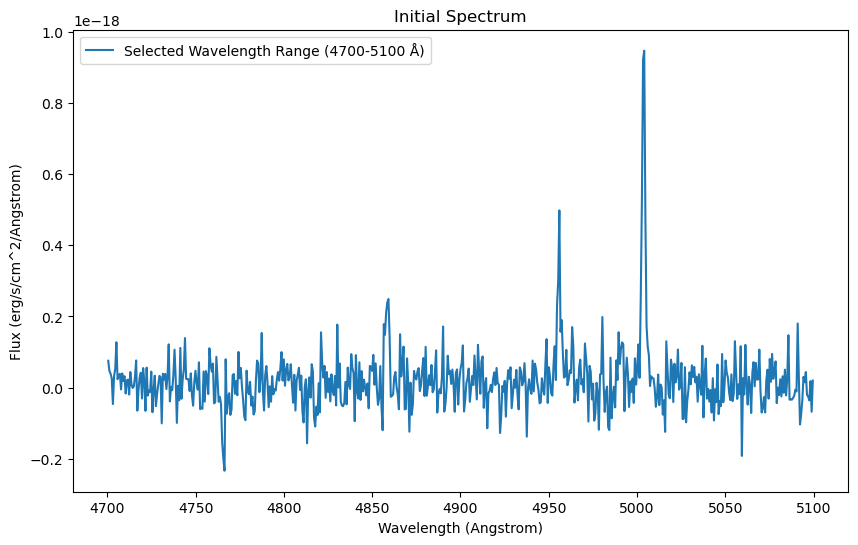


FITTING COMPONENT 1

Component 1 fit parameters:
Amplitude: 9.766265e-19
Mean: 5003.75 Å
Sigma: 0.91 Å
Integrated flux: 1.464373e-21
Integration error: 2.709901e-21


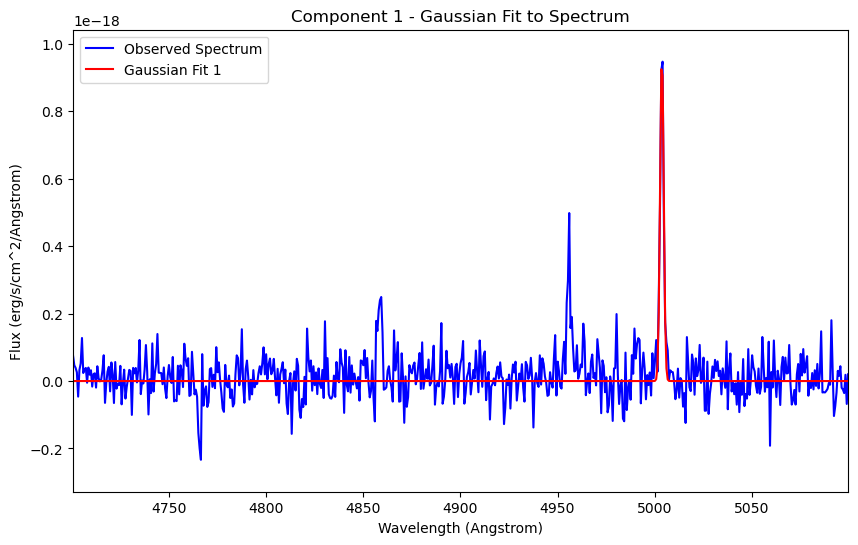

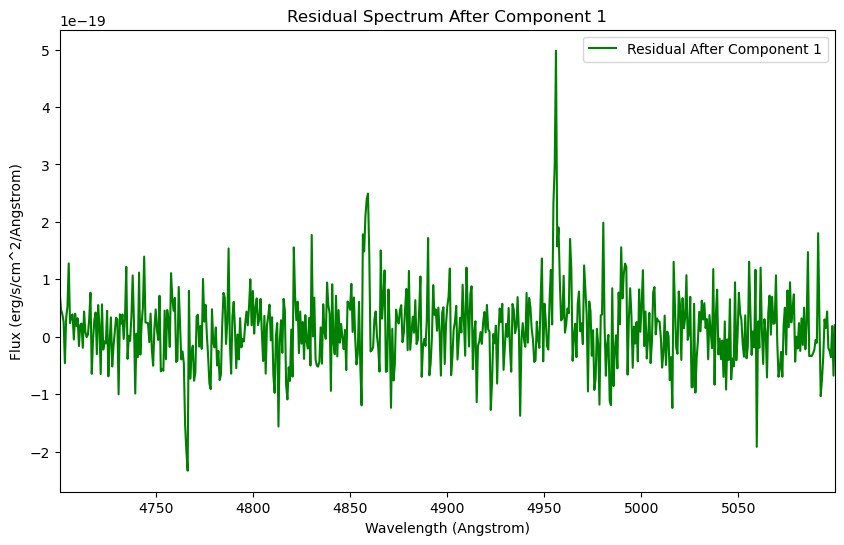


FITTING COMPONENT 2

Component 2 fit parameters:
Amplitude: 3.838636e-19
Mean: 4955.88 Å
Sigma: 1.07 Å
Integrated flux: 4.142625e-18
Integration error: 7.727200e-18


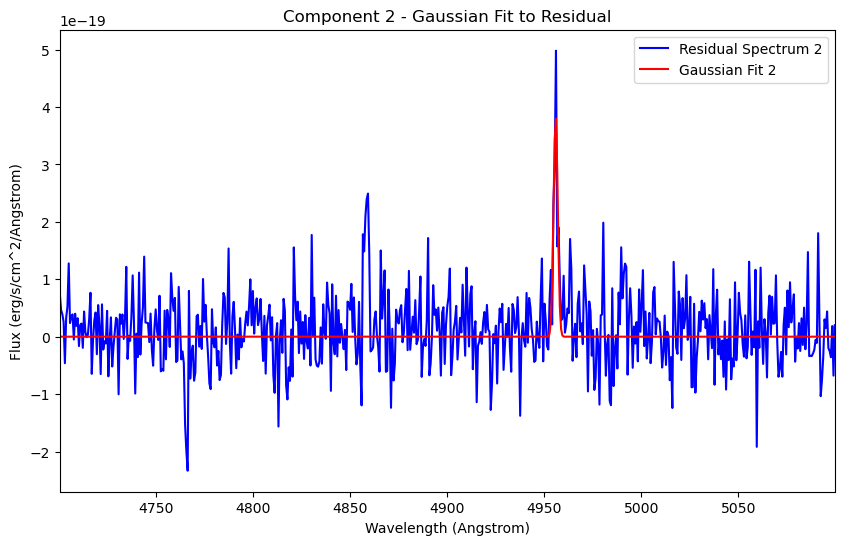

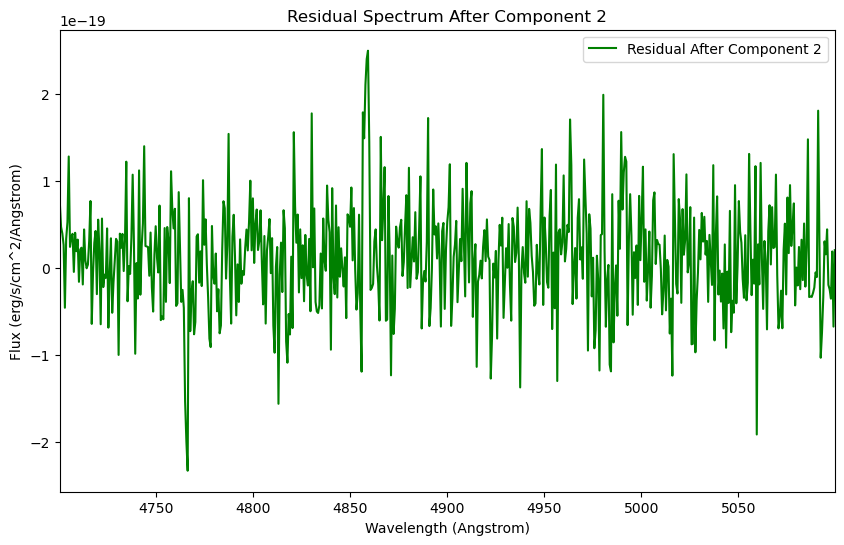


FITTING COMPONENT 3

Component 3 fit parameters:
Amplitude: 2.669308e-19
Mean: 4858.47 Å
Sigma: 1.10 Å
Integrated flux: 6.103356e-19
Integration error: 1.145300e-18


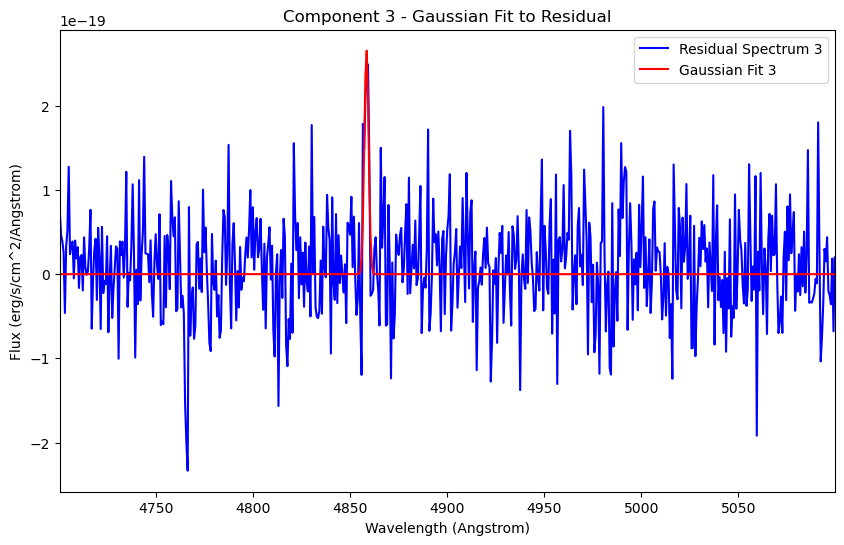

Hβ line detected! Center: 4858.47 Å, Hβ: 4863.0 Å
Difference: 4.53 Å, within 1 nm range
Hβ line detected in component 3 - stopping iteration
Hβ integrated flux: 6.103356e-19
Hβ line detected! Center: 4858.47 Å, Hβ: 4863.0 Å
Difference: 4.53 Å, within 1 nm range


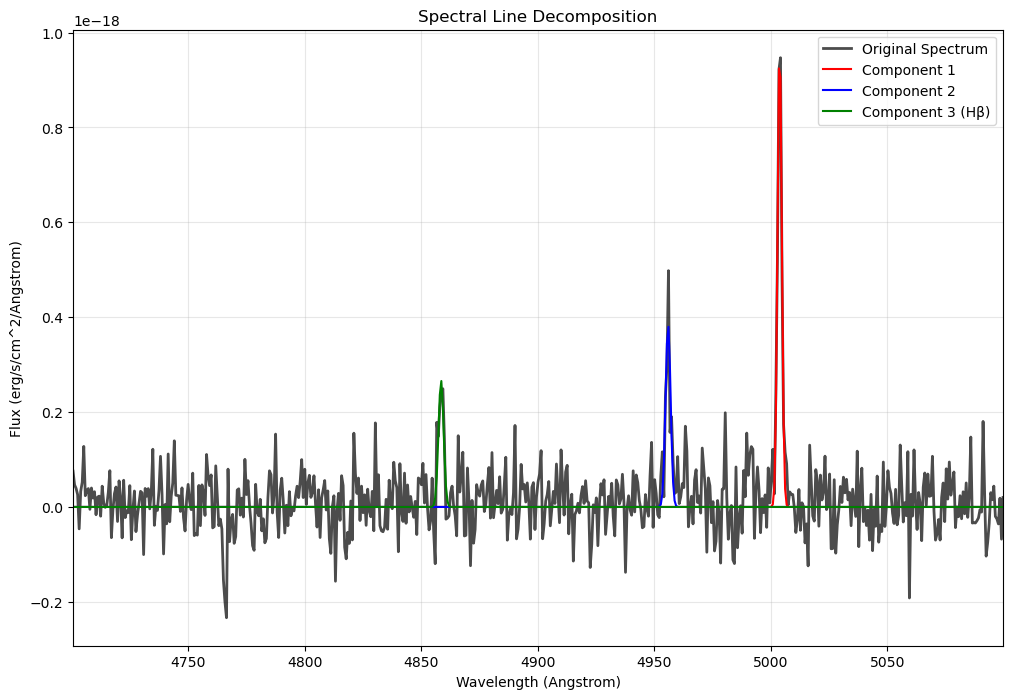


FINAL FITTING SUMMARY
Total components fitted: 3
Hβ integrated flux: 6.103356e-19
Total integrated flux (all components): 4.754425e-18


In [ ]:
def get_total_model(self, wavelength_range):
        """
        Generate the total model spectrum from all fitted components

        Parameters:
        -----------
        wavelength_range : array
            Wavelength values

        Returns:
        --------
        array : Total model flux
        """
        if not self.fit_results:
            return np.zeros_like(wavelength_range)

        total_model = np.zeros_like(wavelength_range)
        for fit_result in self.fit_results:
            if fit_result['success']:
                params = fit_result['parameters']
                total_model += self.gaussian(wavelength_range,
                                           params['amplitude'],
                                           params['mean'],
                                           params['sigma'])

        return total_model# %%
import astropy
import astropy.units as u
import numpy as np
import specutils
import matplotlib.pyplot as plt
import pandas as pd
import inspect
import FunctionLib as FL
import os
import warnings
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils.fitting import find_lines_threshold, find_lines_derivative
from astropy import units as u
from astropy.modeling import models
from scipy.optimize import curve_fit
import scipy

warnings.filterwarnings("ignore", category=UserWarning, append=True)

# %%
class SpectralLineFitter:
    """Class for fitting Gaussian components to spectral lines"""

    def __init__(self, restframe_wavelength=4863.0, max_iterations=800000, max_components=3):
        self.restframe_wavelength = restframe_wavelength
        self.max_iterations = max_iterations
        self.max_components = max_components
        self.fit_results = []

    @staticmethod
    def gaussian(x, amplitude, mean, sigma):
        """Gaussian function for fitting spectral lines"""
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma ** 2))

    def fit_single_gaussian(self, wavelength_range, flux_range):
        """
        Fit a single Gaussian to the given wavelength and flux arrays

        Parameters:
        -----------
        wavelength_range : array
            Wavelength values
        flux_range : array
            Flux values

        Returns:
        --------
        dict : Dictionary containing fit results
        """
        try:
            # Initial parameter guesses
            amplitude_guess = np.max(flux_range) - np.min(flux_range)
            mean_guess = wavelength_range[np.argmax(flux_range)]
            sigma_guess = 1.0
            initial_guess = [amplitude_guess, mean_guess, sigma_guess]

            # Perform fitting
            popt, pcov = curve_fit(self.gaussian, wavelength_range, flux_range,
                                  p0=initial_guess, maxfev=self.max_iterations)

            # Generate fitted curve
            y_fit = self.gaussian(wavelength_range, *popt)

            # Calculate integrated flux
            integrated_flux, integration_error = scipy.integrate.quad(
                self.gaussian, wavelength_range[0], wavelength_range[-1], args=tuple(popt)
            )

            return {
                'success': True,
                'parameters': {'amplitude': popt[0], 'mean': popt[1], 'sigma': popt[2]},
                'fitted_curve': y_fit,
                'integrated_flux': integrated_flux,
                'integration_error': integration_error,
                'covariance': pcov
            }

        except Exception as e:
            print(f"Gaussian fitting failed: {e}")
            return {'success': False, 'error': str(e)}

    def check_hbeta_line(self, mean_fit, sigma_fit):
        """
        Check if the fitted line is Hβ or within 3σ of Hβ or within 1 nanometer
        wavelength of Hβ

        Parameters:
        -----------
        mean_fit : float
            Fitted line center wavelength
        sigma_fit : float
            Fitted line width

        Returns:
        --------
        bool : True if line is Hβ or within 3σ
        """
        wavelength_difference = abs(mean_fit - self.restframe_wavelength)
        three_sigma_range = 3 * abs(sigma_fit)
        one_nanometer_range = 1.0 * u.nm.to(u.angstrom)

        if wavelength_difference <= one_nanometer_range:
            print(f"Hβ line detected! Center: {mean_fit:.2f} Å, Hβ: {self.restframe_wavelength} Å")
            print(f"Difference: {wavelength_difference:.2f} Å, within 1 nm range")
            return True

        if wavelength_difference <= three_sigma_range:
            print(f"Hβ line detected! Center: {mean_fit:.2f} Å, Hβ: {self.restframe_wavelength} Å")
            print(f"Difference: {wavelength_difference:.2f} Å, 3σ range: {three_sigma_range:.2f} Å")
            return True

        return False

    def plot_fit_result(self, wavelength_range, flux_range, fit_result,
                       component_num, is_residual=False):
        """
        Plot spectrum with Gaussian fit overlay

        Parameters:
        -----------
        wavelength_range : array
            Wavelength values
        flux_range : array
            Flux values
        fit_result : dict
            Fit result dictionary
        component_num : int
            Component number for labeling
        is_residual : bool
            Whether this is a residual spectrum plot
        """
        plt.figure(figsize=(10, 6))

        if is_residual:
            plt.plot(wavelength_range, flux_range, label=f'Residual Spectrum {component_num}', color='blue')
            title = f'Component {component_num} - Gaussian Fit to Residual'
        else:
            plt.plot(wavelength_range, flux_range, label='Observed Spectrum', color='blue')
            title = f'Component {component_num} - Gaussian Fit to Spectrum'

        if fit_result['success']:
            plt.plot(wavelength_range, fit_result['fitted_curve'],
                    label=f'Gaussian Fit {component_num}', color='red')

        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
        plt.title(title)
        plt.legend()
        plt.xlim(wavelength_range[0], wavelength_range[-1])

        if not is_residual:
            flux_margin = 0.1 * np.max(flux_range)
            plt.ylim(np.min(flux_range) - flux_margin, np.max(flux_range) + flux_margin)

        plt.show()

    def print_fit_summary(self, fit_result, component_num):
        """Print summary of fit results"""
        if fit_result['success']:
            params = fit_result['parameters']
            print(f"\nComponent {component_num} fit parameters:")
            print(f"Amplitude: {params['amplitude']:.6e}")
            print(f"Mean: {params['mean']:.2f} Å")
            print(f"Sigma: {params['sigma']:.2f} Å")
            print(f"Integrated flux: {fit_result['integrated_flux']:.6e}")
            print(f"Integration error: {fit_result['integration_error']:.6e}")
        else:
            print(f"Component {component_num} fit failed: {fit_result['error']}")

    def iterative_gaussian_fitting(self, wavelength_range, flux_range, plot_results=True):
        """
        Perform iterative Gaussian fitting until Hβ is detected or max components reached

        Parameters:
        -----------
        wavelength_range : array
            Wavelength values
        flux_range : array
            Flux values
        plot_results : bool
            Whether to plot each fit result

        Returns:
        --------
        tuple : (fit_results_list, hbeta_integrated_flux)
        """
        self.fit_results = []
        current_flux = flux_range.copy()
        hbeta_integrated_flux = None

        for component_num in range(1, self.max_components + 1):
            print(f"\n{'='*50}")
            print(f"FITTING COMPONENT {component_num}")
            print(f"{'='*50}")

            # Fit Gaussian to current residual
            fit_result = self.fit_single_gaussian(wavelength_range, current_flux)

            if not fit_result['success']:
                print(f"Failed to fit component {component_num}")
                break

            # Store results
            fit_result['component_number'] = component_num
            fit_result['is_hbeta'] = False  # Default to False
            self.fit_results.append(fit_result)

            # Print summary
            self.print_fit_summary(fit_result, component_num)

            # Plot results
            if plot_results:
                is_residual = component_num > 1
                self.plot_fit_result(wavelength_range, current_flux, fit_result,
                                   component_num, is_residual)

            # Check if this component is Hβ
            params = fit_result['parameters']
            if self.check_hbeta_line(params['mean'], params['sigma']):
                print(f"Hβ line detected in component {component_num} - stopping iteration")
                fit_result['is_hbeta'] = True
                hbeta_integrated_flux = fit_result['integrated_flux']
                print(f"Hβ integrated flux: {hbeta_integrated_flux:.6e}")
                break

            # Subtract fitted component from spectrum for next iteration
            current_flux -= fit_result['fitted_curve']

            # Plot residual after subtraction (except for last component)
            if plot_results and component_num < self.max_components:
                plt.figure(figsize=(10, 6))
                plt.plot(wavelength_range, current_flux, label=f'Residual After Component {component_num}', color='green')
                plt.xlabel('Wavelength (Angstrom)')
                plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
                plt.title(f'Residual Spectrum After Component {component_num}')
                plt.legend()
                plt.xlim(wavelength_range[0], wavelength_range[-1])
                plt.show()

        return self.fit_results, hbeta_integrated_flux

    def get_hbeta_component(self):
        """
        Get the Hβ component from the fit results

        Returns:
        --------
        dict or None : Hβ component fit result, or None if not found
        """
        for fit_result in self.fit_results:
            if fit_result.get('is_hbeta', False):
                return fit_result
        return None

    def get_hbeta_integrated_flux(self):
        """
        Get the integrated flux of the Hβ component

        Returns:
        --------
        float or None : Hβ integrated flux, or None if not found
        """
        hbeta_component = self.get_hbeta_component()
        if hbeta_component:
            return hbeta_component['integrated_flux']
        return None

    def plot_final_decomposition(self, wavelength_range, original_flux):
        """
        Plot the final decomposition showing original spectrum,
        individual components, and total model
        """
        if not self.fit_results:
            print("No fit results available")
            return

        plt.figure(figsize=(12, 8))

        # Plot original spectrum
        plt.plot(wavelength_range, original_flux, 'k-', linewidth=2,
                label='Original Spectrum', alpha=0.7)

        # Plot individual components
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        for i, fit_result in enumerate(self.fit_results):
            if fit_result['success']:
                params = fit_result['parameters']
                component_flux = self.gaussian(wavelength_range,
                                             params['amplitude'],
                                             params['mean'],
                                             params['sigma'])

                label= f'Component {fit_result["component_number"]}'
                if self.check_hbeta_line(params['mean'], params['sigma']):
                    label += ' (Hβ)'
                plt.plot(wavelength_range, component_flux,
                        color=colors[i % len(colors)], linewidth=1.5,
                        label=label)

        # Plot total model
        #total_model = self.get_total_model(wavelength_range)
        #plt.plot(wavelength_range, total_model, 'r-', linewidth=2,
        #        label='Total Model', alpha=0.8)

        plt.xlabel('Wavelength (Angstrom)')
        plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
        plt.title('Spectral Line Decomposition')
        plt.legend()
        plt.xlim(wavelength_range[0], wavelength_range[-1])
        plt.grid(True, alpha=0.3)
        plt.show()

# %%
def main_analysis():
    """Main analysis function using the refactored code"""

    # Load data (keeping original data loading structure)
    DJA_File_Path_str = os.path.expanduser('~/DJAData/')
    DJA_Catalog_DataFrame = pd.read_csv('./DJACatalog.csv')

    if os.path.exists(DJA_File_Path_str):
        DJA_File_list = np.array(os.listdir(DJA_File_Path_str))
        print('Number of files in DJA directory:', len(DJA_File_list))

    DJA_File_List = [f for f in os.listdir('./') if f.startswith('goodsn')]
    print('Number of files in current directory:', len(DJA_File_List))

    # Load spectrum
    redshift_float = FL.Load_Redshift(DJA_Catalog_DataFrame, DJA_File_List[2])
    print('Redshift:', redshift_float)

    Spectrum = FL.Load_N_Rescale_Spectra(os.path.join(DJA_File_Path_str, DJA_File_List[1]))
    Spectrum = FL.Calibrate_Spectra_To_RestFrame(Spectrum, redshift_float)

    # Prepare data
    wavelength_array = Spectrum.wavelength.value
    flux_array = Spectrum.flux.value
    flux_array = np.nan_to_num(flux_array, nan=0.0)  # Handle NaN values

    # Select wavelength range (4700-5100 Å)
    mask_bool = (wavelength_array >= 4700) & (wavelength_array <= 5100)
    wavelength_range = wavelength_array[mask_bool]
    flux_range = flux_array[mask_bool]

    # Plot initial spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_range, flux_range, label='Selected Wavelength Range (4700-5100 Å)')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
    plt.title('Initial Spectrum')
    plt.legend()
    plt.show()

    # Create fitter and perform iterative fitting
    fitter = SpectralLineFitter(restframe_wavelength=4863.0, max_components=10)
    fit_results, hbeta_flux = fitter.iterative_gaussian_fitting(wavelength_range, flux_range)

    # Plot final decomposition
    fitter.plot_final_decomposition(wavelength_range, flux_range)

    # Print final summary
    print(f"\n{'='*60}")
    print("FINAL FITTING SUMMARY")
    print(f"{'='*60}")
    print(f"Total components fitted: {len(fit_results)}")

    # Report Hβ flux specifically
    if hbeta_flux is not None:
        print(f"Hβ integrated flux: {hbeta_flux:.6e}")
    else:
        print("Hβ line not detected in any component")

    # Also show total flux for comparison
    total_integrated_flux = sum([result['integrated_flux'] for result in fit_results if result['success']])
    print(f"Total integrated flux (all components): {total_integrated_flux:.6e}")

    return fitter, fit_results

# %%
# Execute main analysis
if __name__ == "__main__":
    fitter, results = main_analysis()